In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
# % matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

import pandas as pd
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Create CNNs

In [4]:
# dt = 0.1, dx = 1.0, (u,v) = (1, 1)
# the weights matrix
nx = 300
ny = 300
w1 = ([[[[0.0],        # upwind
         [0.2],
         [0.0]],

        [[0.3],
         [-1.0],
         [0.2]],

        [[0.0],
         [0.3],
         [0.0]]]])
w2 = ([[[[0.0],        # central
         [0.15],
         [0.0]],

        [[0.25],
         [-0.8],
         [0.15]],

        [[0.0],
         [0.25],
         [0.0]]]])

In [5]:
#output = tf.keras.layers.Conv2D(8, kernel_size=3, strides=2, padding='SAME',activation='relu', input_shape=input_shape[1:])(values)
init_kernel_1 = w1 #np.random.normal(0, 1, (1, 3, 3, 1)) # input shape, kernel size, filters - need change to exact value for weights
init_kernel_2 = w2
init_bias = np.zeros((1,)) # filters - need change to exact value for bias
kernel_initializer_1 = tf.keras.initializers.constant(init_kernel_1)
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel_2)
bias_initializer = tf.keras.initializers.constant(init_bias)

CNN2D_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
#                                activation='relu',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
#         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
#                                activation='relu',
#                                kernel_initializer=kernel_initializer_2,
#                                bias_initializer=bias_initializer),
])

CNN2D_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
#                                activation='relu',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
#         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
#                                activation='relu',
#                                kernel_initializer=kernel_initializer_2,
#                                bias_initializer=bias_initializer),
])


CNN2D_1.compile(loss="mse", 
                optimizer=keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_2.compile(loss="mse", 
                optimizer=keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999))


CNN2D_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 300, 300, 1)       10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


2022-11-16 22:43:04.881762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/shuheng-mo/opt/anaconda3/envs/taichi-lab/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


## Load data


In [6]:
import math
T = np.zeros([nx,ny])
gamma = 40
# initialise t:
x0 = 0 
y0 = -50
x = np.zeros([1,nx])
y = np.zeros([1,nx])
for ii in range(nx):
    x[0][ii] = -150 + 300/nx*ii
    y[0][ii] = -150 + 300/nx*ii    
for i in range(1,299):
    for j in range(1,299):
        temp1 = -((x[0][i] - x0)**2 + (y[0][j] - y0)**2)
        temp2 = 2*gamma**2
        T[i][j] = math.exp(temp1/temp2)

In [7]:
input_shape = (1,nx,ny,1)
#groups = ['C1','C2','C3','C4','C5','C6','C7','C8']
groups = ['C1']

#values = tf.random.normal(input_shape)
values = np.zeros(input_shape)
values.shape

#print('# of times: ', len(times))
print('# of groups: ', len(groups))
print('values.shape: ', values.shape)

# of groups:  1
values.shape:  (1, 300, 300, 1)


In [8]:
# generate Gaussian with a blob
for i in range(nx):
    for j in range(ny):
        values[0][i][j][0] = T[i][j] #+ Z1[i][j] + Z2[i][j] + Z3[i][j]*0.5

In [9]:
##### generate Gaussian with a blob
for i in range(50):
    for j in range(50):
        values[0][i+225][j+125][0] = values[0][i+225][j+125][0] + 1

# Initial condition

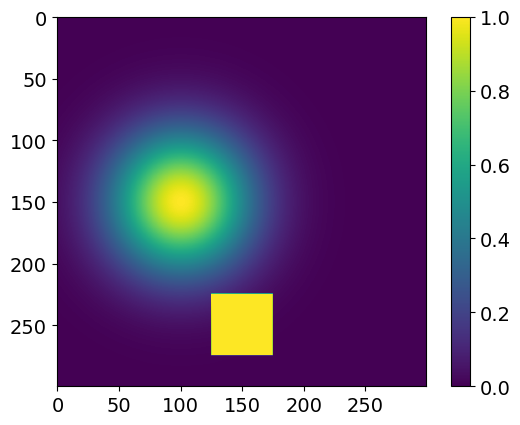

In [10]:
plt.imshow(values[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [11]:
for t in range(200):
    a = CNN2D_1.predict(values) 
    b = (a + values)
    c = (b + values)*0.5
    d = CNN2D_1.predict(c)
    values = values + d
    
#    if t == 0:
#        plt.imshow(values[0,:,:,0], vmin=0, vmax=1.0)
#        plt.axis('off')
#        fig1_name = "paper_figure/figure_1/up_2nd_"+str(t)+".jpg"
#        plt.savefig(fig1_name, dpi=200, bbox_inches='tight')
#        plt.close()
#    elif t ==250 or t == 500 or t == 1000:
#        plt.imshow(values[0,:,:,0], vmin=0, vmax=1.0)
#        plt.axis('off')
#        fig1_name = "paper_figure/figure_1/up_2nd_"+str(t)+".jpg"
#        plt.savefig(fig1_name, dpi=200, bbox_inches='tight')
#        plt.close()

1/1 [==============================] - 0s 16ms/step


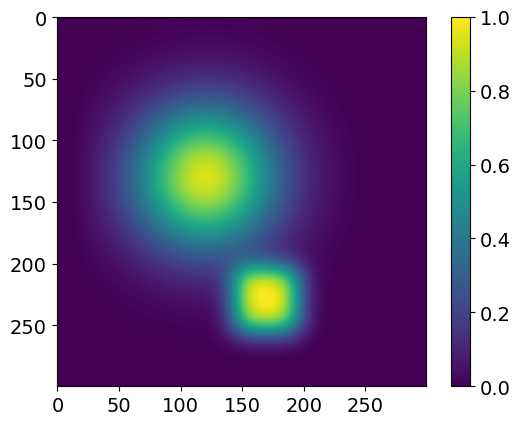

In [12]:
plt.imshow(values[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()